In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

SEED = 472182
random.seed(SEED)
np.random.seed(SEED)

# Conversión a Clasificación

Primero se cargan los datos, que se procesan para separar aquellos que se quieren utilizar, los de sotaveto, y se realiza la partición de train y test.

In [3]:
data = pd.read_csv("wind_ava.csv")
#Esto quita todas las columnas que no terminan en .13
data = data.filter(regex='.*\.13|energy|datetime')
train, test = train_test_split(data, test_size=1099, shuffle=False)

Tras esto se realizará la conversión de la variable objetivo tanto en train como en test. Esta conversión se hace después de realizar la partición ya que en la realidad nuestro modelo no conocerá el quantil de los datos que va a predecir.

Tras la conversión separamos train y test en sus atributos (X) y su variable objetivo (y)

In [4]:
quantile_75per_train = np.quantile(train['energy'], 0.75)

train['energy'] = train['energy'].apply(lambda x: 1 if x > quantile_75per_train else 0)
test['energy'] = test['energy'].apply(lambda x: 1 if x > quantile_75per_train else 0)

X_train = train.drop(['datetime', 'energy'], axis='columns')
y_train = train['energy']

X_test = test.drop(['datetime', 'energy'], axis='columns')
y_test = test['energy']

# Elección del Modelo

Para la elección del modelo se utilizarán distintos modelos y se comparán los resultados que obtienen al realizar la predicción en la partición de train. Esto se realiza para probar varios métodos y poder comparar los resultados entre ellos. 

Para la elección de los hiperparámetros de cada modelo se utilizará GridSearch y como scoring para evaluar cada configuración de hiperparámetros se usar la medida F1-score.
Esta medida se ha elegido dado que consideramos que para las predicciones no es más importante la medida recall sobre la medida precision y viceversa. Por lo tanto F1-score nos permite ponderar ambas medidas en una sola. 

En esta parte de la práctica no se probarán modelos sin hiperparámetros. 

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

best_scores = {}
best_params = {}

## Dummy

Accuracy del dummy: 0.7419590643274855
F1 del dummy: 0.0


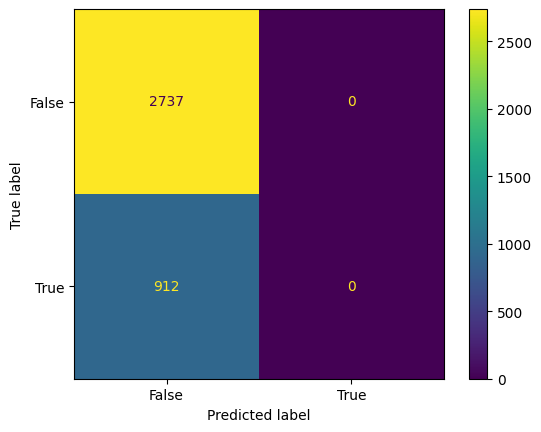

In [6]:
empty_param_grid = {}

pipeline_dummy = Pipeline([('dummy', DummyClassifier(strategy="most_frequent",random_state=SEED))])
dummy_model = GridSearchCV(pipeline_dummy, empty_param_grid, cv=TimeSeriesSplit(n_splits=3))
dummy_model.fit(X_train, y_train)

print(f"Accuracy del dummy: {dummy_model.best_score_}")

pipeline_dummy = Pipeline([('dummy', DummyClassifier(strategy="most_frequent",random_state=SEED))])
dummy_model = GridSearchCV(pipeline_dummy, empty_param_grid, cv=TimeSeriesSplit(n_splits=3),scoring="f1")
dummy_model.fit(X_train, y_train)

y_pred = dummy_model.predict(y_train)
conf_mat = confusion_matrix(y_train, y_pred)

print(f"F1 del dummy: {dummy_model.best_score_}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

El modelo dummy predice siempre la clase más frecuente, en este caso la clase baja, esto se observa en dos situaciones:

- Como podemos ver la accuracy del dummy es muy cercana la 0.75 debido a que se ha realizado la conversión a clasificación a través del 3er cuartil, lo que supone el 75% superior de los datos.

- En cuanto al F1 vemos que su valor es 0, esto ocurre porque los datos están desbalanceados, donde la clase baja es mayoritaria, que se ha traducido como 0, y la clase alta es minoritaria, que se ha traducido como 1. Por lo que tanto las métricas de precision y recall valdrán 0 debido a que nunca se dará un True Positive, es decir, predecir que un 1 es un 1. Esto hace que F1 resulte en 0.

Esto hace que para cualquier predición en la que se de un True Positive sea mejor mejor que la predición del dummy, por lo tanto no es una buena referencia para comparar con los modelos.

## KNN

Los hiperparámetros que se han elegido para la optimización de hiperparámetros del modelo KNN son los mismos que han sido utilizados para el entrenamiento del modelo de la regresión

In [7]:
param_knn = {'knn__n_neighbors': np.arange(2,30,1),
              'knn__weights':  ['uniform','distance'],
              'knn__p': [1,2],
              }

pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_model = GridSearchCV(pipeline_knn, param_knn, cv=TimeSeriesSplit(n_splits=3), scoring= 'f1')

knn_model.fit(X_train, y_train)

best_params['Params elegidos para knn'] = knn_model.best_params_
best_scores['Métrica para knn'] = knn_model.best_score_


print(f"Mejores parametros para KNN: {knn_model.best_params_}")
print(f"Métrica para KNN: {knn_model.best_score_}")

Mejores parametros para KNN: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
Métrica para KNN: 0.6798475570431824


## Árboles de Decisión

Los hiperparámetros que se han elegido para la optimización de hiperparámetros del modelo de árbol de decisión son los mismos que los utilizados para el modelo de árbol de decisión utilizado para la regresión, a excepción del hiperparámetro "class_weight": "balanced", que nos permite ponderar el error de la métrica, de manera que errores en clases minoritarias sean mayores que los errores en clases mayoritarias

In [8]:
tree_params = {'max_depth': np.arange(4,10,2),
               'min_samples_split':np.arange(10,42,2),
               'min_impurity_decrease':[0.0, 1.0],
              'class_weight':['balanced']}

pipeline_tree = DecisionTreeClassifier(random_state = SEED)
tree_model = GridSearchCV(pipeline_tree, tree_params, cv=TimeSeriesSplit(n_splits=3), scoring= 'f1')

tree_model.fit(X_train, y_train)

best_params['Params elegidos para arbol'] = tree_model.best_params_
best_scores['Métrica para arbol'] = tree_model.best_score_

print(f"Mejores parametros para arbol: {tree_model.best_params_}")
print(f"Métrica para arbol: {tree_model.best_score_}")

Mejores parametros para arbol: {'class_weight': 'balanced', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_split': 32}
Métrica para arbol: 0.6990300744077594


## Regresión Logística

Para poder utilizar la regresión como modelo en una clasificación es necesario utilizar la regresión logística. Para la elección de hiperparámetros se ha realizado una investigación de los hiperparámetros que encajan con nuestros datos, buscando minimizar el error obtenido.

En este caso también se ha añadido el hiperparámetro class_weight por la misma razón que se ha comentado en el árbol de decisión 

In [9]:
logistic_reg_params = {'logistic_reg__penalty':["l2"],
                'logistic_reg__C':np.arange(0.1,3,0.5),
                'logistic_reg__class_weight': ["balanced"],
                'logistic_reg__max_iter': [5000, 10000, 20000, 30000],
                'logistic_reg__solver': ["lbfgs","newton-cholesky"]}
pipeline_logistic_reg = Pipeline([('scaler', StandardScaler()), ('logistic_reg', LogisticRegression())])
logistic_reg_model = GridSearchCV(pipeline_logistic_reg, logistic_reg_params, cv=TimeSeriesSplit(n_splits=3), scoring= 'f1')

logistic_reg_model.fit(X_train, y_train)

best_params['Params elegidos para regresión logística'] = logistic_reg_model.best_params_
best_scores['Métrica para regresión logística'] = logistic_reg_model.best_score_

print(f"Mejores parametros para regresión logística: {logistic_reg_model.best_params_}")
print(f"Métrica para regresión logística: {logistic_reg_model.best_score_}")

Mejores parametros para regresión logística: {'logistic_reg__C': 1.1, 'logistic_reg__class_weight': 'balanced', 'logistic_reg__max_iter': 5000, 'logistic_reg__penalty': 'l2', 'logistic_reg__solver': 'newton-cholesky'}
Métrica para regresión logística: 0.5451683802560995


## Máquinas de Vector Soporte

Para la elección de los valores de los hiperparámetros se han utilizado como base los valores de hiperparámetros del modelo pero se han añadido de nuevo el hiperparámetros "class_weight" y en este caso el hiperparámetros "nu" ya que con los valores por defecto el modelo no encontraba solución

In [10]:
svm_params = {'svm__kernel': ["linear","poly","rbf","sigmoid"],
            'svm__degree': np.arange(1,6,1),
            'svm__class_weight':['balanced'],
            'svm__nu': np.arange(0.1,0.5,0.1)}

pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', NuSVC())])
svm_model = GridSearchCV(pipeline_svm, svm_params, cv=TimeSeriesSplit(n_splits=3), scoring= 'f1')

svm_model.fit(X_train, np.ravel(y_train))

best_params['Params elegidos para SVM'] = svm_model.best_params_
best_scores['Métrica para SVM'] = svm_model.best_score_

print(f"Mejores parametros para SVM: {svm_model.best_params_}")
print(f"Métrica para SVM: {svm_model.best_score_}")

Mejores parametros para SVM: {'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__kernel': 'poly', 'svm__nu': 0.30000000000000004}
Métrica para SVM: 0.7075713886675891


# Evaluación del Modelo

## Resultados Finales

In [11]:
print("Mejores parametros elegidos para cada modelo:")
for modelo, param in best_params.items():
    print(f"\t{modelo}: {param}")

print("Best Score de cada modelo:")
for modelo, score in best_scores.items():
    print(f"\t{modelo}: {score}")

Mejores parametros elegidos para cada modelo:
	Params elegidos para knn: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
	Params elegidos para arbol: {'class_weight': 'balanced', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_split': 32}
	Params elegidos para regresión logística: {'logistic_reg__C': 1.1, 'logistic_reg__class_weight': 'balanced', 'logistic_reg__max_iter': 5000, 'logistic_reg__penalty': 'l2', 'logistic_reg__solver': 'newton-cholesky'}
	Params elegidos para SVM: {'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__kernel': 'poly', 'svm__nu': 0.30000000000000004}
Best Score de cada modelo:
	Métrica para knn: 0.6798475570431824
	Métrica para arbol: 0.6990300744077594
	Métrica para regresión logística: 0.5451683802560995
	Métrica para SVM: 0.7075713886675891


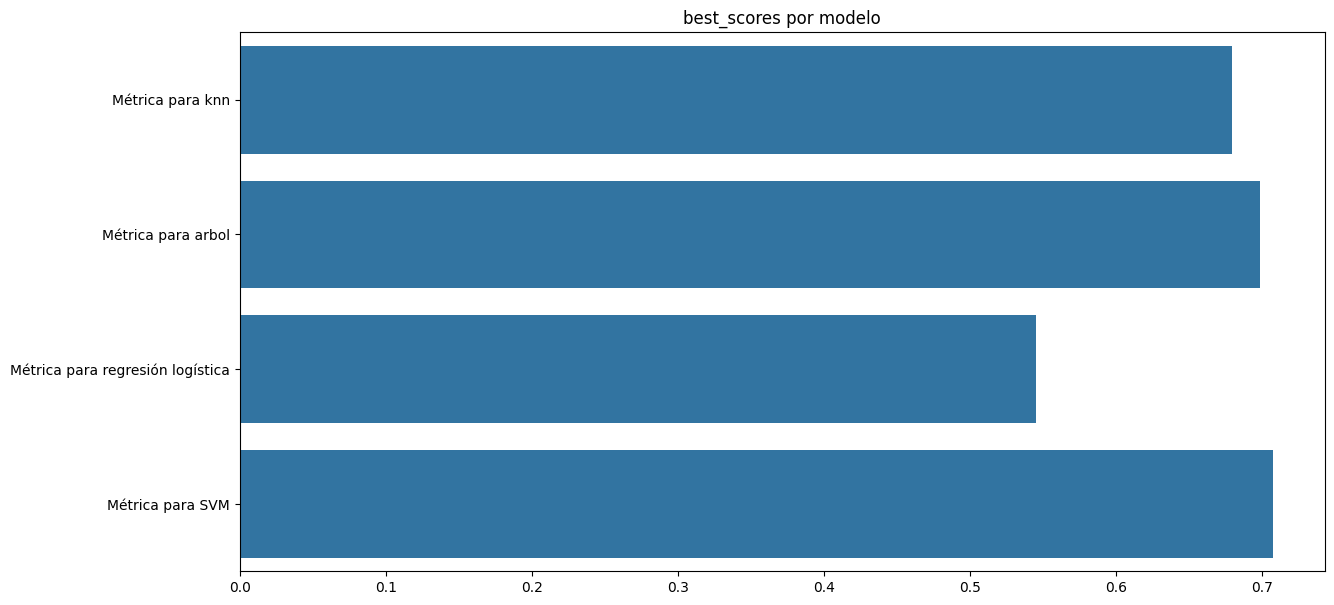

In [12]:
plt.figure(figsize= (14,7))
sns.barplot(data = best_scores, orient='y')
plt.title("best_scores por modelo")
plt.show()

## Elección del modelo y evaluación 

Como podemos observar el modelo que obtiene la mejor puntuación de F1-score es el SVM, el cual obtiene 0.7075 como valor. Por esta razón este será el modelo que utilizaremos para realizar las predicciones. 

Para evaluar el modelo se realizarán las predicciones del conjunto de test, se mostrará la matriz de confusión y se obtendrá la métrica F1-score.

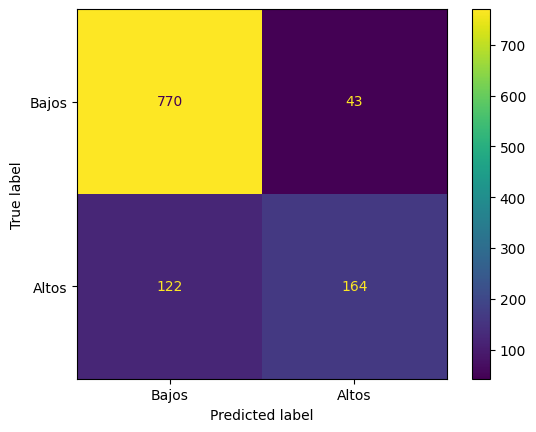

F1-score:0.665314401622718


In [13]:
y_pred=svm_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

outer_score =f1_score(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ["Bajos", "Altos"]) 
cm_display.plot()
plt.show() 
print(f"F1-score:{outer_score}")

Con estos datos se puede concluir que aunque o demasiado correcto, el modelo un mayor número de True positive y True negative que sus contrapartes, lo cual indica que sus predicciones suelen ser correctas aunque por la naturaleza desbalanceada de los datos se predigan más bajos que altos. 

# Modelo Final

Para obtener el modelo final se entrenará con todos los datos del dataset, para conseguir los mejores resultados posibles al aumentar el número de datos de entrenamiento. Este modelo no se usará posteriormente pero sirve como simulación de lo que se realizaría en caso de querer almacenarlo. 

In [14]:
quantile_75per = np.quantile(data['energy'], 0.75)
data['energy'] = data['energy'].apply(lambda x: 1 if x > quantile_75per else 0)


X = data.drop(['datetime', 'energy'], axis='columns')
y = data[['energy']] 
modelo_final = svm_model.fit(X, np.ravel(y))